## Demostrate some of the features of `aiida-castep`

In [2]:
%aiida
from ase import Atoms
import numpy as np
StructureData = DataFactory('structure')
Dict = DataFactory('dict')
KpointsData = DataFactory('array.kpoints')

In [3]:
castep_calc = CalculationFactory('castep.castep')
app = CastepTestApp(None, "/tmp")

In [4]:
from aiida_castep.data.otfg import OTFGData

In [6]:
c9 = OTFGData.get_or_create('C9')[0]

In [ ]:
from aiida_castep.tests.dbtests.conftest import CastepTestApp


In [11]:
## Define a base calculation
# Structure
def generate_base_calc():
    r_unit = 2.6954645
    cell = np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]) * r_unit
    silicon_atoms = Atoms('Si2', cell=cell, scaled_positions=((0, 0, 0), (0.25, 0.25, 0.25)))
    silicon = StructureData(ase=silicon_atoms)

    # Parameters
    param_dict = {
        "CELL":{
            "symmetry_generate": True,
            "snap_to_symmetry": True,
        },
        "PARAM":{
            "task": "singlepoint",
            "cut_off_energy": 300,
            "fix_occupancy": True,
            "opt_strategy": "speed",
            "num_dump_cycles": 0,  
            "write_formatted_density": True
        }}
    param = Dict(dict=param_dict)

    # Kpoints
    kpoints = KpointsData()
    kpoints.set_kpoints_mesh((8, 8, 8), offset=(0,0,0))

    # Define calculation
    builder = castep_calc.get_builder()
    builder.structure = silicon
    builder.parameters = param
    builder.kpoints = kpoints
    builder.metadata.options.resources = {'num_machines': 1}
    builder.metadata.options.max_wallclock_seconds = 600
    builder.pseudos = {'Si': c9}
    builder.metadata.label = "Si SINGELPOINT"
    builder.metadata.description =  "A example CASTEP calculation for silicon"

    return builder
builder = generate_base_calc()

## NOTE
It may seems a lot of effort to define a `CastepCalculation`, but bare in mind that the DFT calculation itself it rather complicate. However, there are various methods implemented to simplify the process.

## Input checking
The package can gather and store the output of `castep -h all` and use it to check if there is any mistake in the keyword names. 

In [3]:
from pprint import pprint

In [4]:
# Print out a summary of the calculation
pprint(calc.get_castep_input_summary())

{'CELL': {'snap_to_symmetry': True, 'symmetry_generate': True},
 'PARAM': {'cut_off_energy': 300,
           'fix_occupancy': True,
           'num_dump_cycles': 0,
           'opt_strategy': 'speed',
           'task': 'singlepoint',
           'write_formatted_density': True},
 'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'computer': <Computer: localhost (localhost), pk: 1>,
 'custom_scheduler_commands': '',
 'kpoints': 'Kpoints mesh: 8x8x8 (+0.0,0.0,0.0)',
 'label': 'Si SINGELPOINT',
 'pseudos': {'Si': u'C18'},
 'resources': {'num_machines': 1},
 'structure': {'cell': [[2.6954645, 2.6954645, 0.0],
                        [2.6954645, 0.0, 2.6954645],
                        [0.0, 2.6954645, 2.6954645]],
               'formula': 'Si2',
               'label': u''},
 'wallclock': 600}


In [5]:
# Lets introduce a mistke and see what happens
calc = generate_base_calc()
param_dict = calc.inp.parameters.get_dict()
param_dict["PARAM"]['write_checkpoints'] = 'none'
calc.inp.parameters.set_dict(param_dict)
pprint(param_dict)
calc.submit_test()

{'CELL': {'snap_to_symmetry': True, 'symmetry_generate': True},
 'PARAM': {'cut_off_energy': 300,
           'fix_occupancy': True,
           'num_dump_cycles': 0,
           'opt_strategy': 'speed',
           'task': 'singlepoint',
           'write_checkpoints': 'none',
           'write_formatted_density': True}}


HelperCheckError: keyword write_checkpoints is not found
(Maybe you wanted to specify one of these: write_checkpoint, checkpoint, write_orbitals?)

In [6]:
# You also update the parameters using update_parameters methods
calc = generate_base_calc()
calc.update_parameters(mixing_scheme='pulay',
                       write_checkpoint='none',
                       xc_functional='pbe',
                       delete=['fix_occupancy']
                       )
calc.submit_test()

(<aiida.common.folders.Folder at 0x7f9b41635e90>, '_aiidasubmit.sh')

In [7]:
# Any any mistake will be caught immeidately using the `update_parameters` method
calc = generate_base_calc()
calc.update_parameters(write_bib=False, write_otfgs=False)

HelperCheckError: Following keys are invalid -- write_otfgs: (Maybe you wanted to specify one of these: write_otfg, write_orbitals, write_none?); 

In [8]:
# As a result, the input parameters are not updated
pprint(calc.inp.parameters.get_dict())

{'CELL': {'snap_to_symmetry': True, 'symmetry_generate': True},
 'PARAM': {'cut_off_energy': 300,
           'fix_occupancy': True,
           'num_dump_cycles': 0,
           'opt_strategy': 'speed',
           'task': 'singlepoint',
           'write_formatted_density': True}}


## Creating restarts easily
Quite often you will have to restart calculation, either entirely new or dependent on an existing one.
This can be done easily with `aiida-castep`

In [9]:
base_calc = generate_base_calc()
# This create a new calculation with inputs of the old calcluation, ignoring the state of the old
new_calc = base_calc.create_restart(ignore_state=True)

# Notice that the uuid of the inputs are the same - they are the same nodes, reused
print("\nOld calc")
pprint(base_calc.get_inputs_dict())
print("\nNew calc")
pprint(new_calc.get_inputs_dict())


Old calc
{'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'kpoints': <KpointsData: uuid: 18ad467f-3b52-4b7b-aaf1-b396deca83d5 (unstored)>,
 'parameters': <ParameterData: uuid: 1ffec976-2a00-4c8b-82bd-3f1f49af2c69 (unstored)>,
 'pseudo_Si': <OTFGData: uuid: 7872e4f6-753a-463c-a738-00880d2dc2ce (pk: 151)>,
 'structure': <StructureData: uuid: 154dd99a-40fd-4502-ab35-98f7217383c0 (unstored)>}

New calc
{'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'kpoints': <KpointsData: uuid: 18ad467f-3b52-4b7b-aaf1-b396deca83d5 (unstored)>,
 'parameters': <ParameterData: uuid: 1ffec976-2a00-4c8b-82bd-3f1f49af2c69 (unstored)>,
 'pseudo_Si': <OTFGData: uuid: 7872e4f6-753a-463c-a738-00880d2dc2ce (pk: 151)>,
 'structure': <StructureData: uuid: 154dd99a-40fd-4502-ab35-98f7217383c0 (unstored)>}


In [10]:
# Another commoon practice is to change some parameters when restarting
base_calc = generate_base_calc()
base_calc.inp.parameters.store()  # Store the parameters node so it cannot be change
new_calc = base_calc.create_restart(ignore_state=True, 
                                    param_update={'cut_off_energy': 500},
                                    #param_delete=['write_checkpoint'],
                                    #reuse=True,
                                    #restart_type='continuation'
                                   )

# Notice that a new parameter node is used for the restart
print("Old calc")
pprint(base_calc.get_inputs_dict())
print("New calc")
pprint(new_calc.get_inputs_dict())

Old calc
{'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'kpoints': <KpointsData: uuid: 300f90a1-c176-4f29-868b-4851a1ec7f8f (unstored)>,
 'parameters': <ParameterData: uuid: be9c08c7-b0ab-40e0-9eaa-3bc456e2ceec (pk: 177)>,
 'pseudo_Si': <OTFGData: uuid: 7872e4f6-753a-463c-a738-00880d2dc2ce (pk: 151)>,
 'structure': <StructureData: uuid: f60ffc88-2647-44aa-9447-4004711cfd5d (unstored)>}
New calc
{'code': <Code: Remote code 'castep-18.1' on localhost, pk: 158, uuid: 45db94ca-aa67-4ced-b79e-36894d926301>,
 'kpoints': <KpointsData: uuid: 300f90a1-c176-4f29-868b-4851a1ec7f8f (unstored)>,
 'parameters': <ParameterData: uuid: 604d93ed-76b3-4bf8-b7da-5e5958f8a8de (unstored)>,
 'pseudo_Si': <OTFGData: uuid: 7872e4f6-753a-463c-a738-00880d2dc2ce (pk: 151)>,
 'structure': <StructureData: uuid: f60ffc88-2647-44aa-9447-4004711cfd5d (unstored)>}


Using the `create_restart` method, it is easiy to restart failed runs or reuse/continue from finished runs.

Below is a example of using this interface to quickly setup a series of convergence test by varying the `cut_off_energy`.

In [11]:
import time

In [12]:
base_calc = generate_base_calc()
base_calc.update_parameters(cut_off_energy=120)
base_calc.store_all(); base_calc.submit()
# Wait for the first calculation to be finished
while not base_calc.has_finished():
    time.sleep(5)
    
print("Submitting tests")
test_calcs = []
for cut in range(100, 250, 30):
    conv_test = base_calc.create_restart(reuse=True, param_update={'cut_off_energy': cut})
    conv_test.label += " CUT {}".format(cut)
    conv_test.description = "Convergence test, using different cut_off_energy"
    conv_test.store_all(); conv_test.submit()
    test_calcs.append(conv_test)
    
    

cut_test_group = Group.get_or_create(name='conv_test_si')[0]
cut_test_group.add_nodes([base_calc] + test_calcs)

Submitting tests


## Note
A better way to do this kind of tests is to define a function using ``@workfunction`` or sub-class a ``WorkChain`` which (when done propertly) is robust to local machine shutdowns. This allows the test itself to be recorded in the database and linked to individual calculations.
[more detail](https://aiida-core.readthedocs.io/en/stable/work/index.html?highlight=workchain)

In [13]:
!verdi calculation list -p1 -a --project pk ctime state sched label

# Last daemon state_updater check: 0h:00m:01s ago (at 19:05:37 on 2019-03-20)
  PK  Creation    State     Sched. state    Label
----  ----------  --------  --------------  ----------------------
 162  15m ago     FINISHED  DONE            Si SINGLEPOINT
 171  7m ago      FINISHED  DONE            Si SINGLEPOINT
 181  5m ago      FINISHED  DONE            Si SINGELPOINT
 188  4m ago      FINISHED  DONE            Si SINGELPOINT CUT 100
 190  4m ago      FINISHED  DONE            Si SINGELPOINT CUT 130
 192  4m ago      FINISHED  DONE            Si SINGELPOINT CUT 160
 194  4m ago      FINISHED  DONE            Si SINGELPOINT CUT 190
 196  4m ago      FINISHED  DONE            Si SINGELPOINT CUT 220

Total results: 8



<IPython.core.display.Javascript object>


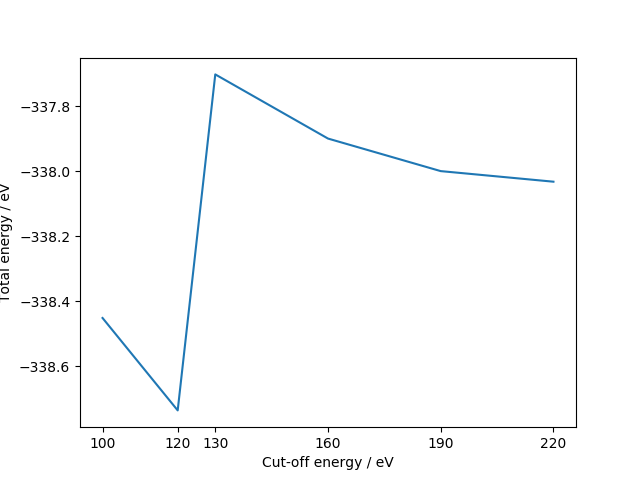

Text(0,0.5,'Total energy / eV')

In [14]:
## Plot
%matplotlib notebook
import matplotlib.pyplot as plt
data = [(node.inp.parameters.get_dict()["PARAM"]["cut_off_energy"],
         node.res.total_energy) for node in cut_test_group.nodes]
data.sort(key=lambda x: x[0])
cut_eng = np.array(data)
plt.plot(cut_eng[:, 0], cut_eng[:, 1])
plt.xlabel("Cut-off energy / eV")
plt.xticks(cut_eng[:, 0]) 
plt.ylabel("Total energy / eV")

## Graphos

In [15]:
from IPython.display import Image

Output file is 196.png


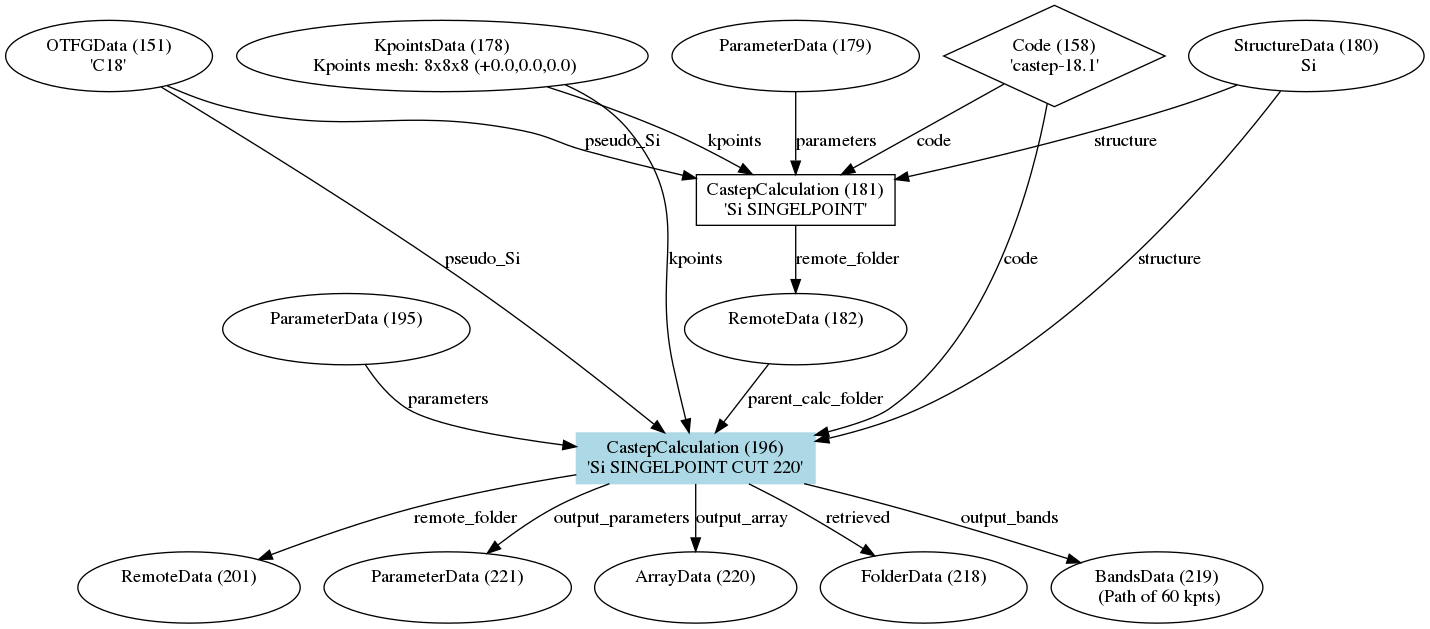

In [16]:
!verdi graph generate -f png -d 10 {conv_test.pk}  --inputs
Image("{}.png".format(conv_test.pk))

Output file is 181.png


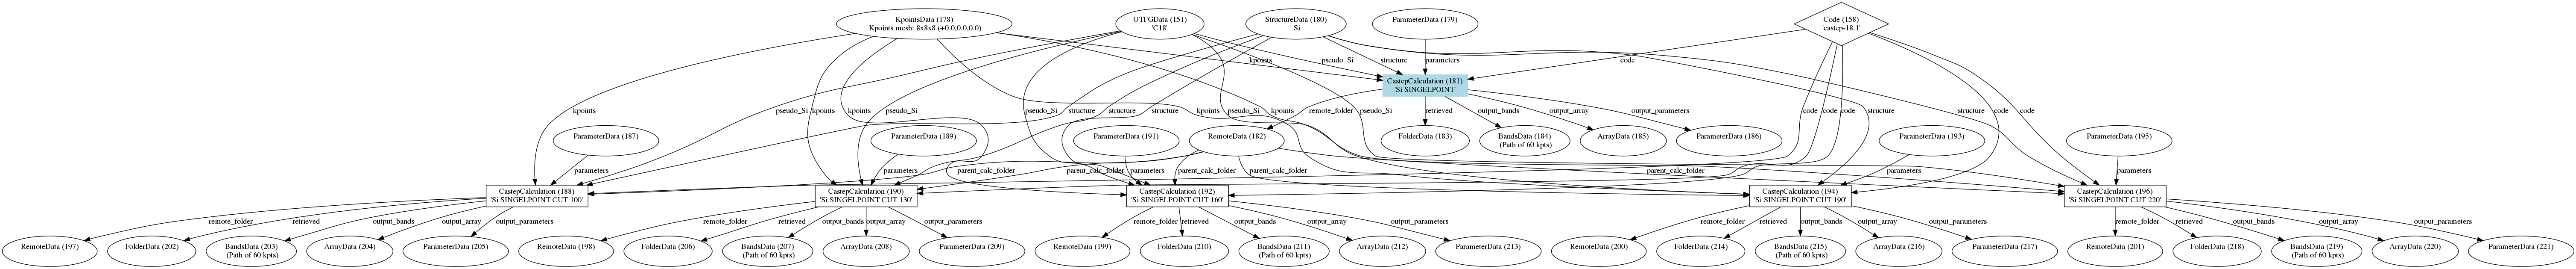

In [17]:
!verdi graph generate -f png -d 10 {base_calc.pk}  --inputs
Image("{}.png".format(base_calc.pk))